In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
from tqdm.notebook import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# load words
words = open("names.txt").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
DELIMITER = "."
chars = sorted(set(list("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi.update({".": 0})
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)


# pretty print
skip_index = 27
items = [(i, itos.get(i)) for i in range(len(itos)) if i != skip_index]

first_col = items[: len(items) // 2 + len(items) % 2]
second_col = items[len(items) // 2 + len(items) % 2 :]

for first, second in zip(first_col, second_col + [(None, None)]):
    first_str = f"{first[0]:>2} -> {first[1]}"
    second_str = f"{second[0]:>2} -> {second[1]}" if second[0] is not None else ""
    print(f"{first_str}\t\t{second_str}")

 0 -> .		14 -> n
 1 -> a		15 -> o
 2 -> b		16 -> p
 3 -> c		17 -> q
 4 -> d		18 -> r
 5 -> e		19 -> s
 6 -> f		20 -> t
 7 -> g		21 -> u
 8 -> h		22 -> v
 9 -> i		23 -> w
10 -> j		24 -> x
11 -> k		25 -> y
12 -> l		26 -> z
13 -> m		


Build the dataset

In [4]:
# architecture
CONTEXT_LENGTH = 5
N_EMBEDDINGS = 12
N_HIDDEN = 1024
# training
BATCH_SIZE = 64
EPOCHS = 300_000
LR_START = 0.3
LR_END = 0.001
K = 9  # LR decay rate

random.seed(42)
random.shuffle(words)  # shuffles in place


def build_dataset(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []

    for word in words:
        context = [0] * CONTEXT_LENGTH
        for char in word + DELIMITER:
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


splits = int(0.8 * len(words)), int(0.9 * len(words))

X_train, Y_train = build_dataset(words[: splits[0]])
X_dev, Y_dev = build_dataset(words[splits[0] : splits[1]])
X_test, Y_test = build_dataset(words[splits[1] :])

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [5]:
g = torch.Generator().manual_seed(2147483647)
kaiming_init = (5 / 3) / (N_EMBEDDINGS * CONTEXT_LENGTH) ** 0.5
# Tensors
C = torch.randn([vocab_size, N_EMBEDDINGS], generator=g)
W1 = torch.randn([N_EMBEDDINGS * CONTEXT_LENGTH, N_HIDDEN], generator=g) * kaiming_init
b1 = torch.randn([N_HIDDEN], generator=g) * 0.01
W2 = torch.randn([N_HIDDEN, vocab_size], generator=g) * 0.01
b2 = torch.randn([vocab_size], generator=g) * 0.01

# normalization gain and shift
batch_norm_gain = torch.ones([1, N_HIDDEN])
batch_norm_bias = torch.zeros([1, N_HIDDEN])

parameters = [C, W1, b1, W2, b2, batch_norm_gain, batch_norm_bias]

# add gradients
for p in parameters:
    p.requires_grad = True

In [6]:
print(f"Number of parameters in model: {sum(p.nelement() for p in parameters):,}")

Number of parameters in model: 92,511


Training

In [7]:
lri = []
lossi = []
stepi = []

progress_bar = tqdm(
    range(EPOCHS), desc="Epoch", miniters=20, mininterval=0.5, maxinterval=1
)

for i in progress_bar:
    batch_indices = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))

    # forward pass
    embeddings = C[X_train[batch_indices]]
    h_pre_activation = embeddings.view(-1, N_EMBEDDINGS * CONTEXT_LENGTH) @ W1 + b1
    h_pre_activation_norm = (
        batch_norm_gain
        * (h_pre_activation - h_pre_activation.mean(0, keepdim=True))
        / h_pre_activation.std(0, keepdim=True)
    ) + batch_norm_bias
    h = torch.tanh(h_pre_activation_norm)
    if i == 0:
        h_i1 = h
        print("Saved first `h` tensor")
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[batch_indices])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = LR_END + (LR_START - LR_END) * math.exp(-K * (i / EPOCHS))
    for p in parameters:
        p.data += -lr * p.grad

    # tracking
    stepi.append(i)
    lri.append(lr)
    lossi.append(loss.item())

    progress_bar.set_postfix(
        loss=f"{loss:6f}",
        lr=f"{lr:.6f}",
        tanh_saturation=f"{(h.abs() > 0.99).float().mean().item():.6f}",
        refresh=False,
    )

Epoch:   0%|          | 0/300000 [00:00<?, ?it/s]

Saved first `h` tensor


---
Analyzing `h` (tanh) distribution

(array([1540., 1459., 1305., 1270., 1268., 1226., 1133., 1278., 1167.,
        1157., 1096., 1109., 1153., 1177., 1041., 1114.,  903.,  986.,
         963., 1105.,  925.,  935., 1028.,  934., 1011.,  828.,  971.,
        1019., 1019.,  859.,  894.,  905.,  838.,  819.,  942., 1001.,
         942.,  856.,  893.,  943.,  991., 1078., 1097.,  981.,  964.,
        1238., 1058., 1107., 1104., 1180., 1110., 1154., 1157., 1296.,
        1233., 1181., 1235., 1321., 1419., 1620.]),
 array([-9.99839962e-01, -9.66514091e-01, -9.33188220e-01, -8.99862349e-01,
        -8.66536478e-01, -8.33210607e-01, -7.99884737e-01, -7.66558866e-01,
        -7.33232995e-01, -6.99907124e-01, -6.66581253e-01, -6.33255382e-01,
        -5.99929512e-01, -5.66603641e-01, -5.33277770e-01, -4.99951899e-01,
        -4.66626028e-01, -4.33300157e-01, -3.99974287e-01, -3.66648416e-01,
        -3.33322545e-01, -2.99996674e-01, -2.66670803e-01, -2.33344932e-01,
        -2.00019062e-01, -1.66693191e-01, -1.33367320e-01, -1.0004

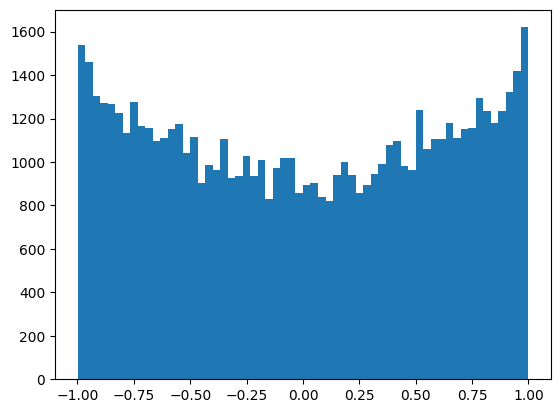

In [8]:
plt.hist(h_i1.view(-1).tolist(), 60)

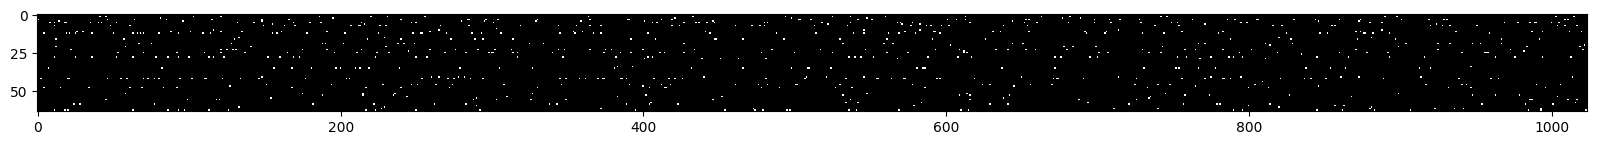

In [9]:
plt.figure(figsize=(20, 10))
plt.imshow(h_i1.abs() > 0.99, cmap="grey", interpolation="nearest")

---

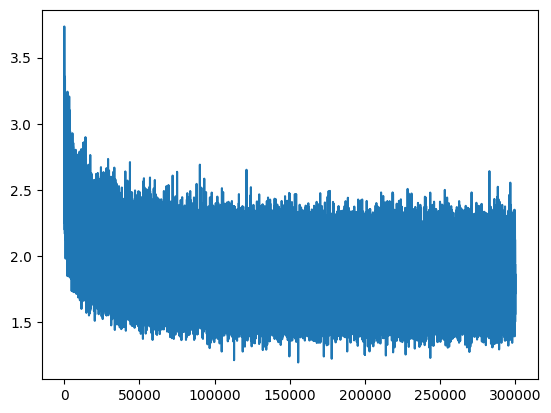

In [10]:
plt.plot(stepi, lossi)

Calibrate batch norm at end of training

In [11]:
with torch.no_grad():
    embeddings = C[X_train]
    h_pre_activation = embeddings.view(-1, N_EMBEDDINGS * CONTEXT_LENGTH) @ W1 + b1
    batch_norm_mean = h_pre_activation.mean(0, keepdim=True)
    batch_norm_std = h_pre_activation.std(0, keepdim=True)

In [12]:
# loss on whole training set
embeddings = C[X_train]
h_pre_activation = embeddings.view(-1, N_EMBEDDINGS * CONTEXT_LENGTH) @ W1 + b1
h_pre_activation_norm = (
    batch_norm_gain * ((h_pre_activation - batch_norm_mean) / batch_norm_std)
    + batch_norm_bias
)
h = torch.tanh(h_pre_activation_norm)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print(loss)

tensor(1.7939, grad_fn=<NllLossBackward0>)


In [13]:
# loss on dev set
embeddings = C[X_dev]
h_pre_activation = embeddings.view(-1, N_EMBEDDINGS * CONTEXT_LENGTH) @ W1 + b1
h_pre_activation_norm = (
    batch_norm_gain * ((h_pre_activation - batch_norm_mean) / batch_norm_std)
    + batch_norm_bias
)
h = torch.tanh(h_pre_activation_norm)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
print(loss)

tensor(1.9984, grad_fn=<NllLossBackward0>)


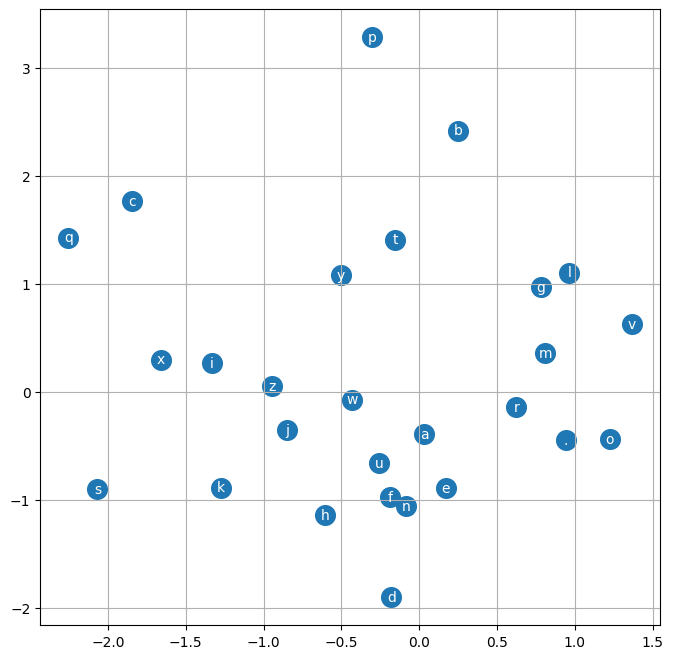

In [14]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(),
        C[i, 1].item(),
        itos[i],
        ha="center",
        va="center",
        color="white",
    )
plt.grid("minor")

Sample

In [15]:
g = torch.Generator().manual_seed(2147483647 + 10)
generated_names = []

for _ in range(20):
    out = []
    context = [0] * CONTEXT_LENGTH
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h_pre_activation = emb.view(-1, N_EMBEDDINGS * CONTEXT_LENGTH) @ W1 + b1
        h_pre_activation_norm = (
            batch_norm_gain * ((h_pre_activation - batch_norm_mean) / batch_norm_std)
            + batch_norm_bias
        )
        h = torch.tanh(h_pre_activation_norm)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    generated_names.append("".join(itos[i] for i in out))
for name in generated_names:
    print(name)

montay.
yazmie.
lendyn.
alexzier.
jendram.
cailee.
meliah.
miloen.
edelina.
anara.
mykiah.
kalin.
shubhrgahima.
steller.
jenique.
paim.
uriel.
dariyah.
faela.
kayshawn.


In [16]:
[w for w in generated_names if w[:-1] in words]

['montay.',
 'cailee.',
 'meliah.',
 'anara.',
 'kalin.',
 'uriel.',
 'dariyah.',
 'kayshawn.']

## Pytorchifying

In [412]:
from src.makemore.part3 import Linear, BatchNorm1d, Tanh

In [413]:
# architecture
CONTEXT_LENGTH = 5
N_EMBEDDINGS = 12
N_HIDDEN = 256
# training
BATCH_SIZE = 64
EPOCHS = 200_000
LR_START = 4
LR_END = 0.07
K = 4  # LR decay rate

g = torch.Generator().manual_seed(2147483647)

In [414]:
X_train, Y_train = build_dataset(words[: splits[0]])
X_dev, Y_dev = build_dataset(words[splits[0] : splits[1]])
X_test, Y_test = build_dataset(words[splits[1] :])

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [415]:
C = torch.randn((vocab_size, N_EMBEDDINGS), generator=g)

layers = [
    Linear(N_EMBEDDINGS * CONTEXT_LENGTH, N_HIDDEN, generator=g, bias=False),
    BatchNorm1d(N_HIDDEN),
    Tanh(),
    Linear(N_HIDDEN, N_HIDDEN, generator=g, bias=False),
    BatchNorm1d(N_HIDDEN),
    Tanh(),
    Linear(N_HIDDEN, N_HIDDEN, generator=g, bias=False),
    BatchNorm1d(N_HIDDEN),
    Tanh(),
    Linear(N_HIDDEN, N_HIDDEN, generator=g, bias=False),
    BatchNorm1d(N_HIDDEN),
    Tanh(),
    Linear(N_HIDDEN, N_HIDDEN, generator=g, bias=False),
    BatchNorm1d(N_HIDDEN),
    Tanh(),
    Linear(N_HIDDEN, vocab_size, generator=g, bias=False),
    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # num of parameters
for p in parameters:
    p.requires_grad = True

287354


In [416]:
ud = []
lri = []
lossi = []
stepi = []
progress_bar = tqdm(
    range(EPOCHS), desc="Epoch", miniters=20, mininterval=0.5, maxinterval=1
)

for i in progress_bar:
    ix = torch.randint(0, X_train.shape[0], (BATCH_SIZE,), generator=g)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    embeddings = C[X_batch]
    x = embeddings.view(-1, N_EMBEDDINGS * CONTEXT_LENGTH)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = LR_END + (LR_START - LR_END) * math.exp(-K * (i / EPOCHS))
    for p in parameters:
        if p.grad is not None:
            p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lri.append(lr)
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append(
            [
                (lr * p.grad.std() / p.data.std()).log10().item()
                for p in parameters
                if isinstance(p.grad, torch.Tensor)
            ]
        )
    progress_bar.set_postfix(loss=f"{loss:6f}", lr=f"{lr:.6f}", refresh=False)

Epoch:   0%|          | 0/200000 [00:00<?, ?it/s]

### Visualizations

#### Activation Distribution

Layer  2, (Tanh) : mean +0.03, std 0.76, saturated 25.98%
Layer  5, (Tanh) : mean -0.01, std 0.77, saturated 24.75%
Layer  8, (Tanh) : mean +0.01, std 0.80, saturated 25.38%
Layer 11, (Tanh) : mean +0.01, std 0.81, saturated 29.36%
Layer 14, (Tanh) : mean -0.01, std 0.85, saturated 40.95%


Text(0.5, 1.0, 'Activation Distribution')

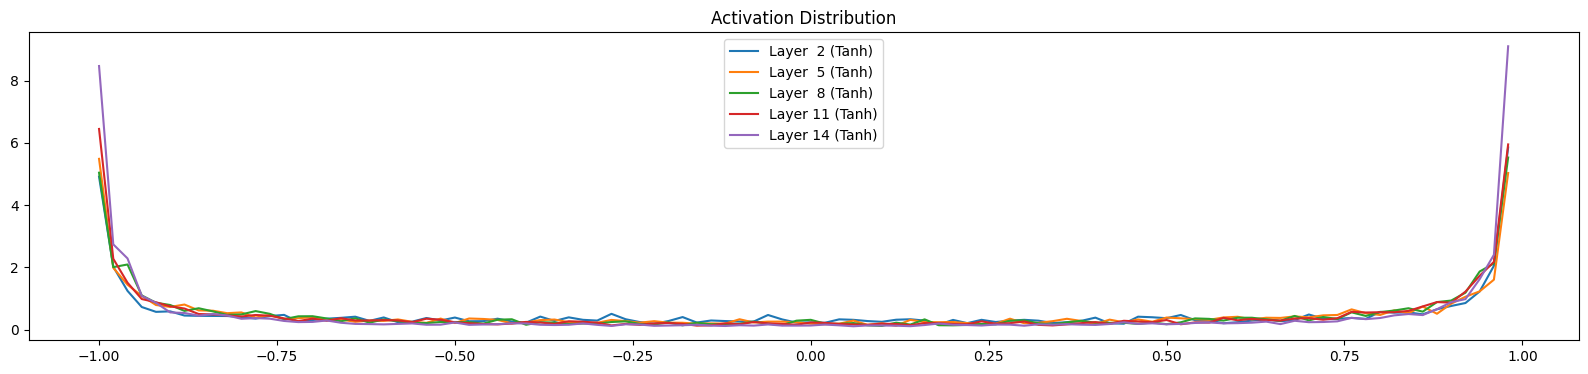

In [417]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            f"Layer {i:2}, {'(' + layer.__class__.__name__ + ')':6}",
            f": mean {t.mean():+.2f}, std {t.std():.2f}, "
            f"saturated {(t.abs() > 0.97).float().mean()*100:.2f}%",
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i:2} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Activation Distribution")

#### Gradient Distribution

Layer  2 (Tanh): mean +0.00, std 0.00
Layer  5 (Tanh): mean -0.00, std 0.00
Layer  8 (Tanh): mean -0.00, std 0.00
Layer 11 (Tanh): mean -0.00, std 0.00
Layer 14 (Tanh): mean +0.00, std 0.00


Text(0.5, 1.0, 'Gradient Distribution')

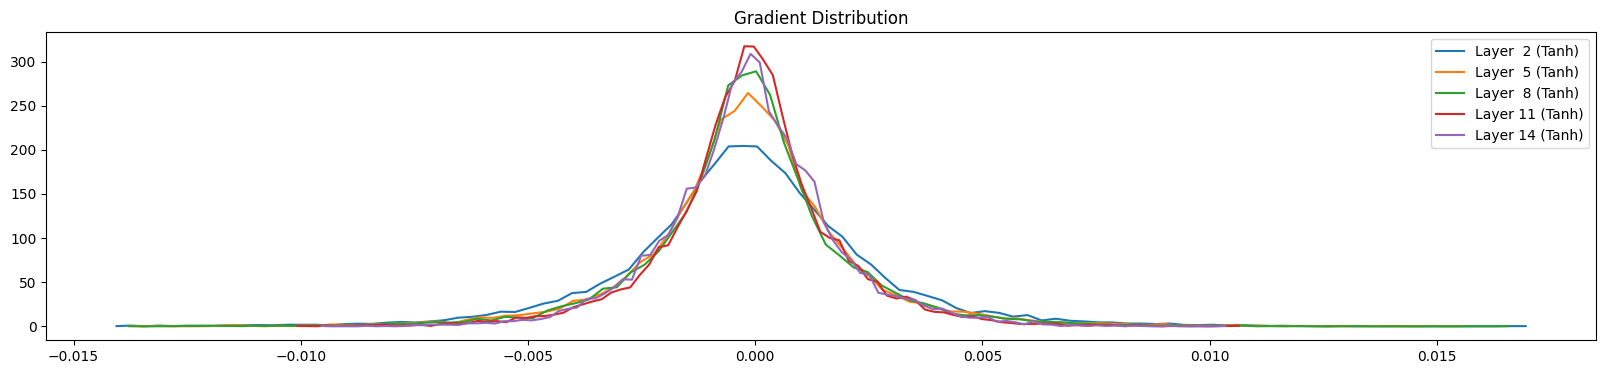

In [418]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        if t is not None:
            print(
                f"Layer {i:2} ({layer.__class__.__name__}): mean {t.mean():+.2f}, std {t.std():.2f}"
            )
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"Layer {i:2} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Gradient Distribution")

#### Weights Gradient Distribution

Weights shape: (  27,   12)  | mean -0.000000 | std 0.006123  | grad:data ratio 1.873947e-03
Weights shape: (  60,  256)  | mean +0.000003 | std 0.001510  | grad:data ratio 8.557726e-04
Weights shape: ( 256,  256)  | mean -0.000003 | std 0.000563  | grad:data ratio 3.350164e-04
Weights shape: ( 256,  256)  | mean +0.000001 | std 0.000491  | grad:data ratio 2.911019e-04
Weights shape: ( 256,  256)  | mean +0.000002 | std 0.000465  | grad:data ratio 2.780578e-04
Weights shape: ( 256,  256)  | mean -0.000000 | std 0.000384  | grad:data ratio 2.296293e-04
Weights shape: ( 256,   27)  | mean +0.000002 | std 0.001107  | grad:data ratio 6.383188e-04


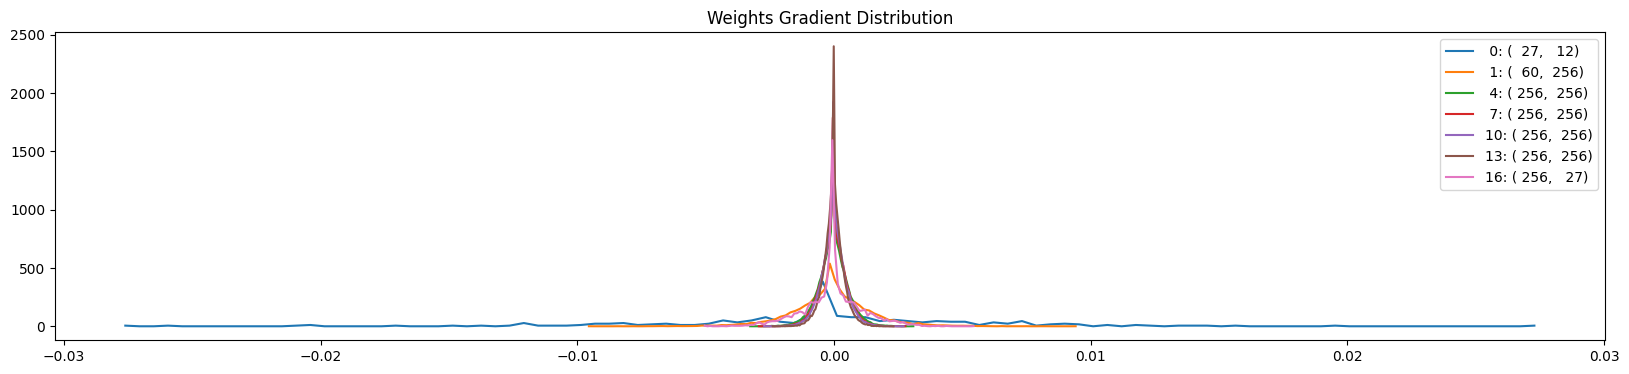

In [419]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if t is not None:
        if p.ndim == 2:
            print(
                f"Weights shape: ({p.shape[0]:4}, {p.shape[1]:4})",
                f" | mean {t.mean():+6f} | std {t.std():6f}",
                f" | grad:data ratio {t.std()/p.std():e}",
            )
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"{i:2}: ({p.shape[0]:4}, {p.shape[1]:4})")
    plt.legend(legends)
    plt.title("Weights Gradient Distribution")

#### Update rate ratio

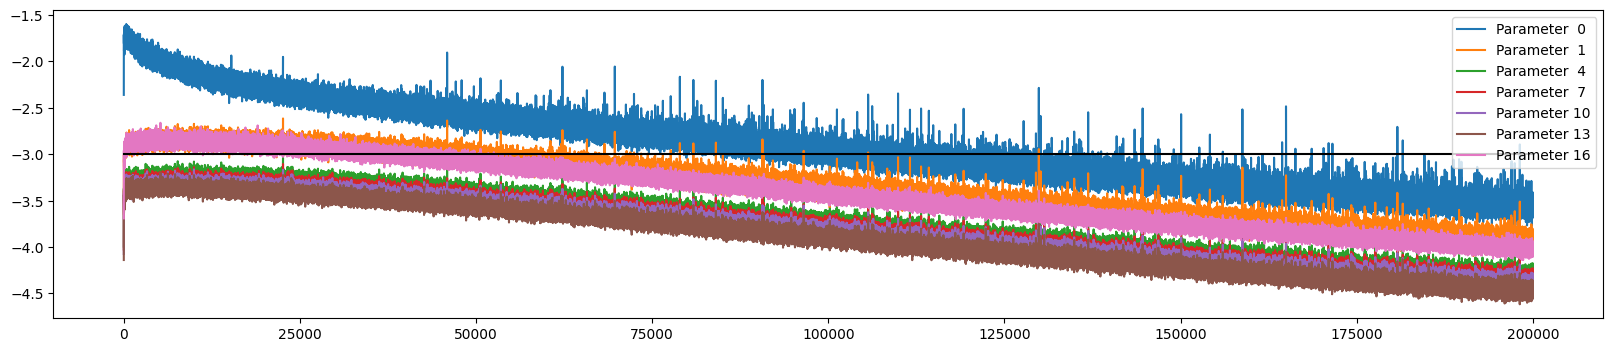

In [420]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"Parameter {i:2}")
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)

In [421]:
@torch.no_grad()
def split_loss(split: str) -> None:
    x, y = {
        "train": (X_train, Y_train),
        "val": (X_dev, Y_dev),
        "test": (X_test, Y_test),
    }[split]

    embeddings = C[x]
    x = embeddings.view(embeddings.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())


# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss("train")
split_loss("val")

train 1.7097687721252441
val 2.0283970832824707
